In [36]:
# 時系列データのさまざまな異常・変化の例

In [37]:
import os
import re
import sys
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels
import pmdarima
# import pycaret
# import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

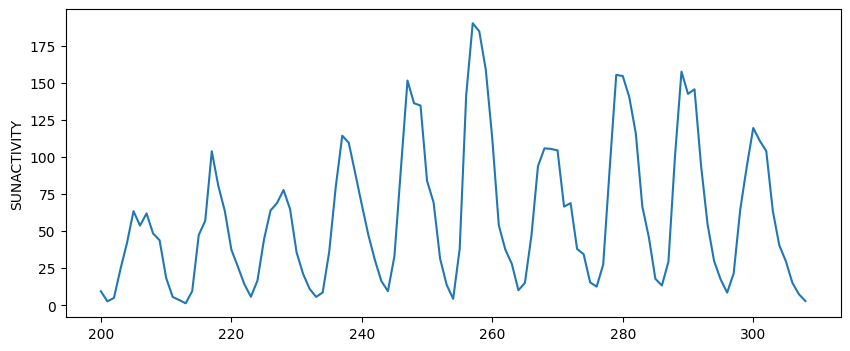

In [38]:
# statsmodelsライブラリのサンプルデータ・太陽黒点数からデータフレームを取得
# (Yearly (1700-2008) data on sunspots from the National Geophysical Data Center. Public domain data)
# 1900年以降のデータを利用
sunspot_df = statsmodels.api.datasets.sunspots.load_pandas().data[200:]
# print('DataFrame.shape:', sunspot_df.shape) # データフレームの形状を表示
# print(sunspot_df.head(3))  # 先頭3行を表示
# print(sunspot_df.tail(3))  # 先頭3行を表示
fig, ax = plt.subplots(1, 1, figsize=(10,4)) # 折れ線グラフでデータを表示
ax.set_ylabel('SUNACTIVITY')
g = ax.plot(sunspot_df.SUNACTIVITY)

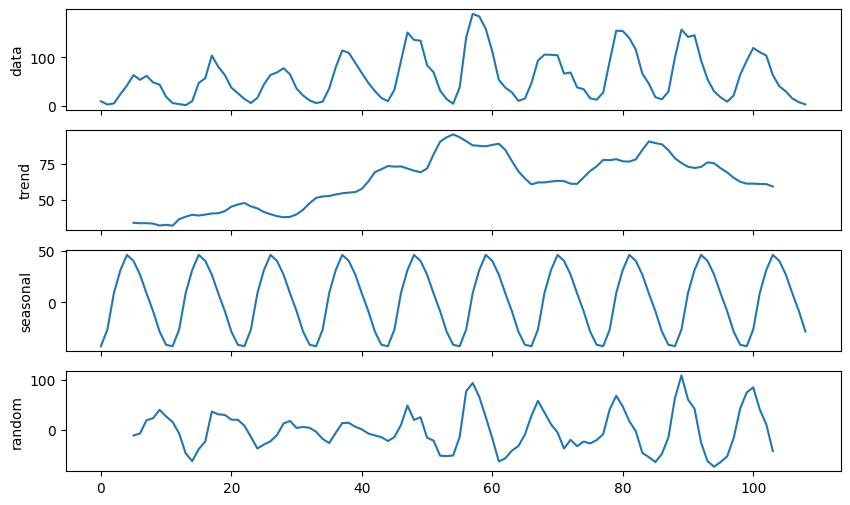

In [39]:
# 時系列データの成分分解（data -> tread, seasonal, random）
data = sunspot_df.SUNACTIVITY.values
_decomposed = pmdarima.arima.decompose(data, 'additive', m=11) # 時系列データを成分分解 
# print('Decomposed:', _decomposed) # 分解されたデータを表示
pmdarima.utils.decomposed_plot(_decomposed, figure_kwargs={'figsize': (10, 6)}) # 分解されたデータをプロット
plt.show()

In [40]:
# 定常性の検定（ADF検定、P値が0.05以上ならば非定常）
p_value = statsmodels.tsa.stattools.adfuller(sunspot_df['SUNACTIVITY'])[1]
print(f'P値: {p_value:.3f}')

P値: 0.379


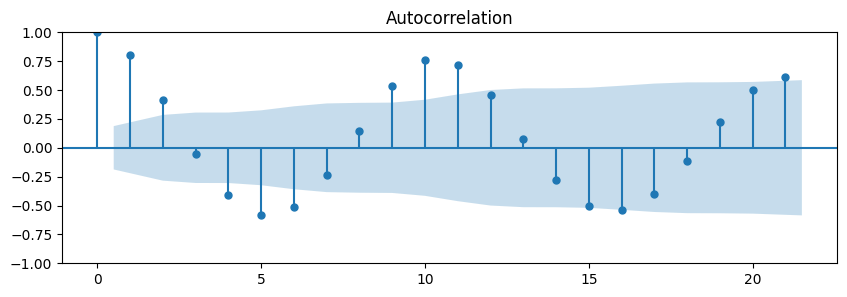

In [41]:
# 自己相関を確認（背景部が95%信頼区間、その外が自己相関あり）
fig, ax = plt.subplots(figsize=(10, 3))
statsmodels.graphics.tsaplots.plot_acf(data, ax=ax)
plt.show()

## 2004年以前のデータ数: 104 2005年以降のデータ数: 5
次数探索の結果  ARIMA(2,1,2)(0,0,0)[11]          
MAE: 18.020, MSE: 463.019, MAPE: 3.315


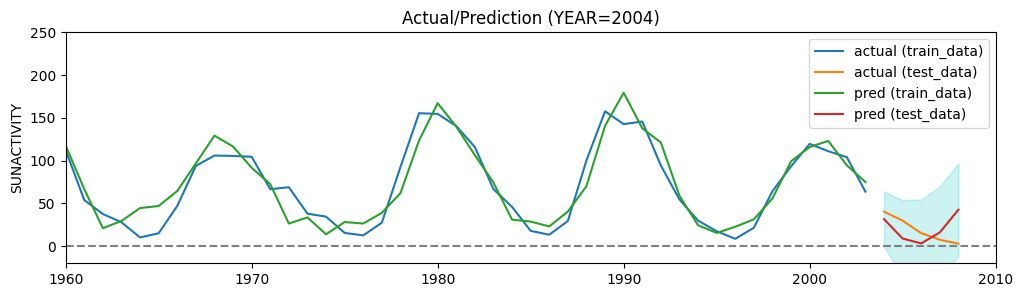

## 2000年以前のデータ数: 100 2001年以降のデータ数: 9
次数探索の結果  ARIMA(3,0,0)(0,0,2)[11] intercept
MAE: 14.696, MSE: 392.283, MAPE: 2.339


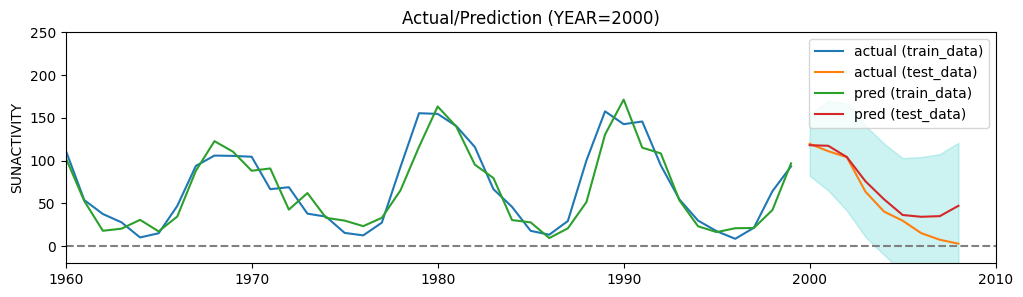

## 1994年以前のデータ数: 94 1995年以降のデータ数: 15
次数探索の結果  ARIMA(1,1,0)(2,0,0)[11]          
MAE: 21.780, MSE: 938.659, MAPE: 0.626


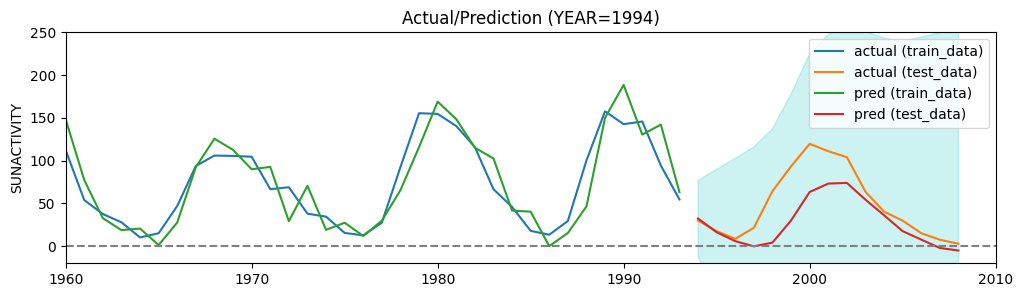

## 1986年以前のデータ数: 86 1987年以降のデータ数: 23
次数探索の結果  ARIMA(1,1,0)(1,0,0)[11]          
MAE: 53.787, MSE: 4382.860, MAPE: 1.200


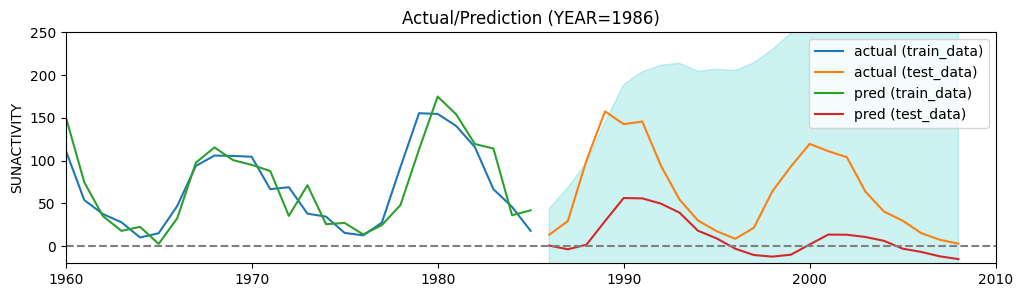

In [42]:
# サンプルデータを学習用の過去データと、テスト用の未来データに分割 (1999年以前を学習データ、2000年以降をテストデータ)
for YEAR in [2004, 2000, 1994, 1986]:
    train_sunspot_df = sunspot_df[sunspot_df.YEAR < YEAR]
    test_sunspot_df = sunspot_df[sunspot_df.YEAR >= YEAR]
    print(f'## {YEAR}年以前のデータ数: {train_sunspot_df.shape[0]} {YEAR+1}年以降のデータ数: {test_sunspot_df.shape[0]}')

    # 次数探索を行い、最適次数でモデルを作成し、学習データで学習
    auto_model = pmdarima.auto_arima(train_sunspot_df.SUNACTIVITY.values, seasonal=True, m=11)
    print('次数探索の結果', auto_model)

    ##学習データの期間とテストデータの期間をモデルでそれぞれ予測
    train_pred = auto_model.predict_in_sample()
    test_pred, test_pred_ci = auto_model.predict(n_periods=test_sunspot_df.shape[0], return_conf_int=True)

    # 予測誤差を計算して表示
    _mae = mean_absolute_error(test_sunspot_df.SUNACTIVITY, test_pred)
    _mse = mean_squared_error(test_sunspot_df.SUNACTIVITY, test_pred)
    _mape = mean_absolute_percentage_error(test_sunspot_df.SUNACTIVITY, test_pred)
    print(f'MAE: {_mae:.3f}, MSE: {_mse:.3f}, MAPE: {_mape:.3f}')

    # 結果をグラフで表示
    fig, ax = plt.subplots(1, 1, figsize=(12,3))
    ax.set_ylabel('SUNACTIVITY')
    g = ax.plot(train_sunspot_df.YEAR, train_sunspot_df.SUNACTIVITY, label="actual (train_data)")
    g = ax.plot(test_sunspot_df.YEAR, test_sunspot_df.SUNACTIVITY, label="actual (test_data)")
    g = ax.plot(train_sunspot_df.YEAR, train_pred, label="pred (train_data)")
    g = ax.plot(test_sunspot_df.YEAR, test_pred, label="pred (test_data)")
    ax.fill_between(test_sunspot_df.YEAR, test_pred_ci[:, 0], test_pred_ci[:, 1], color='c', alpha=.2)
    g = ax.set_title(f'Actual/Prediction (YEAR={YEAR})')
    g = ax.set_xlim(1960, 2010)
    g = ax.set_ylim(-20, 250)
    g = ax.hlines(0, 1960, 2010, 'gray', linestyles='dashed')
    g = ax.legend()
    plt.show()